In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from skimage.color import *
import cv2
from my_commonfunctions import *
from tqdm import trange

In [3]:
test3_gray = (my_imread_gray('ym_test.png'))
test3_w1500_gray = (my_imread_gray('test3_w1500.png')*255).astype(np.uint8)
test5_gray = (my_imread_gray('test5.png')*255).astype(np.uint8)
Beethoven_gray = (my_imread_gray('Beethoven_Op026-01_001.png')).astype(np.uint8)

In [4]:
test3_bin_bg_white = test3_gray > 200
test3_w1500_bin_bg_white = test3_w1500_gray > 200
test5_bin_bg_white = test5_gray > 200
Beethoven_bin_bg_white = Beethoven_gray > 200

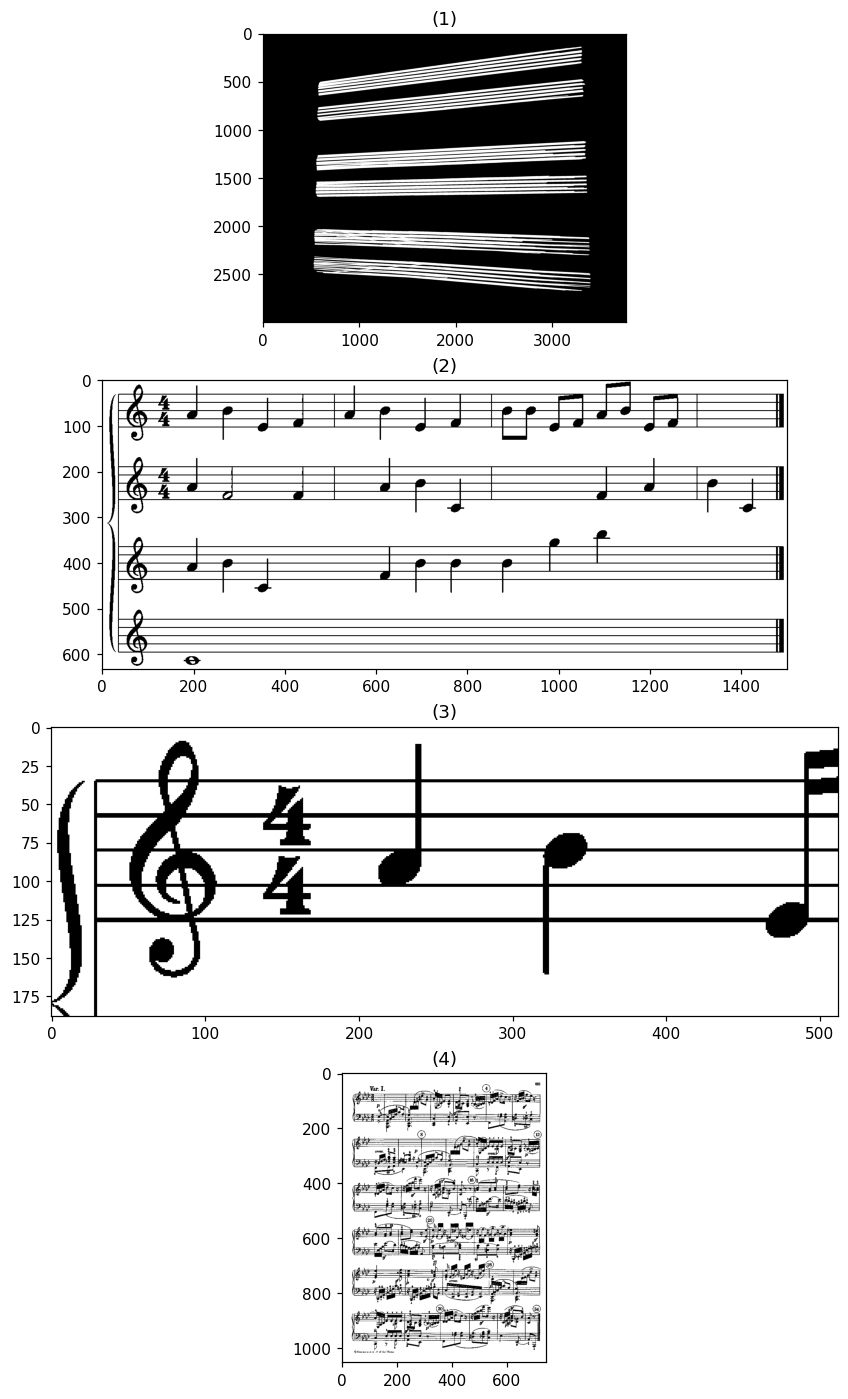

In [6]:
my_show_images([test3_bin_bg_white, test3_w1500_bin_bg_white, test5_bin_bg_white, Beethoven_bin_bg_white], dpi=110, row_max=1)

In [7]:
def get_distance_between_staves(img_binary_bg_white):
    img_height = img_binary_bg_white.shape[0]
    
    flattened = img_binary_bg_white.T.flatten()
    flattened_indices = np.arange(0, flattened.shape[0], 1, np.uint32)
    flattened[flattened_indices % img_height == 0] = False # Separate each column with a black pixel
    
    image, contours, hierarchy = cv2.findContours((flattened*255).astype(np.uint8), 
                                              cv2.RETR_TREE, 
                                              cv2.CHAIN_APPROX_SIMPLE)
    
    # We refer to length as the vertical distance between 2 black pixels
    length_freq = np.zeros((img_height), dtype=np.uint32) # No contour can be taller than img_height because we separated each column with a black pixel
    all_possible_lengths = np.arange(0, img_height, 1, dtype=np.uint32)
    for i in contours:
        contour_y = i.T[1]
        length = contour_y[0][1] - contour_y[0][0] if len(contour_y[0]) == 2 else 1
        length_freq[length] += 1
        
    return all_possible_lengths[length_freq == length_freq.max()][0]

In [8]:
def get_line_separation_kernel_size_from_distance_between_staves(distance_between_staves):
    if distance_between_staves % 2 == 0:
        return distance_between_staves + 9
    else:
        return distance_between_staves + 8

In [11]:
def get_sperated_lines(img_binary_bg_white, distance_between_staves):
    '''
    Return a list of images
    '''
    
    img_gray_uint8 = img_binary_bg_white
    
    # 1. Canny
    #edges = cv2.Canny(img_gray_uint8, 100, 200)
    edges = img_binary_bg_white
    
    # 2. Closing
    kernel_size = get_line_separation_kernel_size_from_distance_between_staves(distance_between_staves)
    #print(kernel_size)
    k = np.ones((kernel_size, kernel_size))
    closed = my_close(edges, k)
    
    my_show_images([edges, closed], dpi=110, row_max=1)
    
    # 3. White pixels freq in each row
    closed_bin = closed > 200
    sum_of_rows = np.sum(closed_bin, axis=1) # Sum of each row
    img_width = img_gray_uint8.shape[1]
    is_line = (sum_of_rows / img_width) > 0.8 # Normalization & thresholding (If percentage of white pixels of each row is 80% or higher, this row is considered a line)
    
    # 4. Contours of is_line
    image, init_contours, hierarchy = cv2.findContours((is_line*255).astype(np.uint8), 
                                              cv2.RETR_TREE, 
                                              cv2.CHAIN_APPROX_SIMPLE)
    # 4.1 Remove from init_contours any contour described by other than 2 points
    init_contours_length = len(init_contours)
    i = 0
    while i < init_contours_length:
        l = init_contours[i]
        #print("------\n", l, len(l))
        if len(l) != 2:
            init_contours.pop(i)
            init_contours_length -= 1
            i -= 1
        i += 1
    
    init_contours = np.array(init_contours).squeeze()
    init_contours_y = init_contours.T[1].T
    
    # 5. Mid point between each 2 contours
    init_contours_y_flattened_sorted = np.sort(init_contours_y.flatten())
    init_contours_y_flattened_sorted_2_consecutive = init_contours_y_flattened_sorted[1:-1].reshape(-1, 2)
    init_contour_y_mid_points = np.mean(init_contours_y_flattened_sorted_2_consecutive, axis=1).astype(np.uint32)
    
    # 6. Final contours
    img_height = img_gray_uint8.shape[0]
    final_contours_y = np.append(np.array([0]), init_contour_y_mid_points) # Add 0 @ the beginning
    final_contours_y = np.append(final_contours_y, np.array([img_height])) # Add img_height @ the end
    
    # 7. The return list
    final_lines = []
    for i in range(len(final_contours_y)-1):
        x0 = 0
        x1 = img_width
        y0 = final_contours_y[i]
        y1 = final_contours_y[i+1]
        final_lines.append(img_gray_uint8[y0:y1, x0:x1])   
        
    return final_lines

# The Following Cell Is My Stuff

In [10]:
img_bin_bg_white = test3_gray
distance_between_staves = get_distance_between_staves(img_bin_bg_white)
lines = get_sperated_lines(img_bin_bg_white, distance_between_staves)

NameError: name 'img_gray_uint8' is not defined

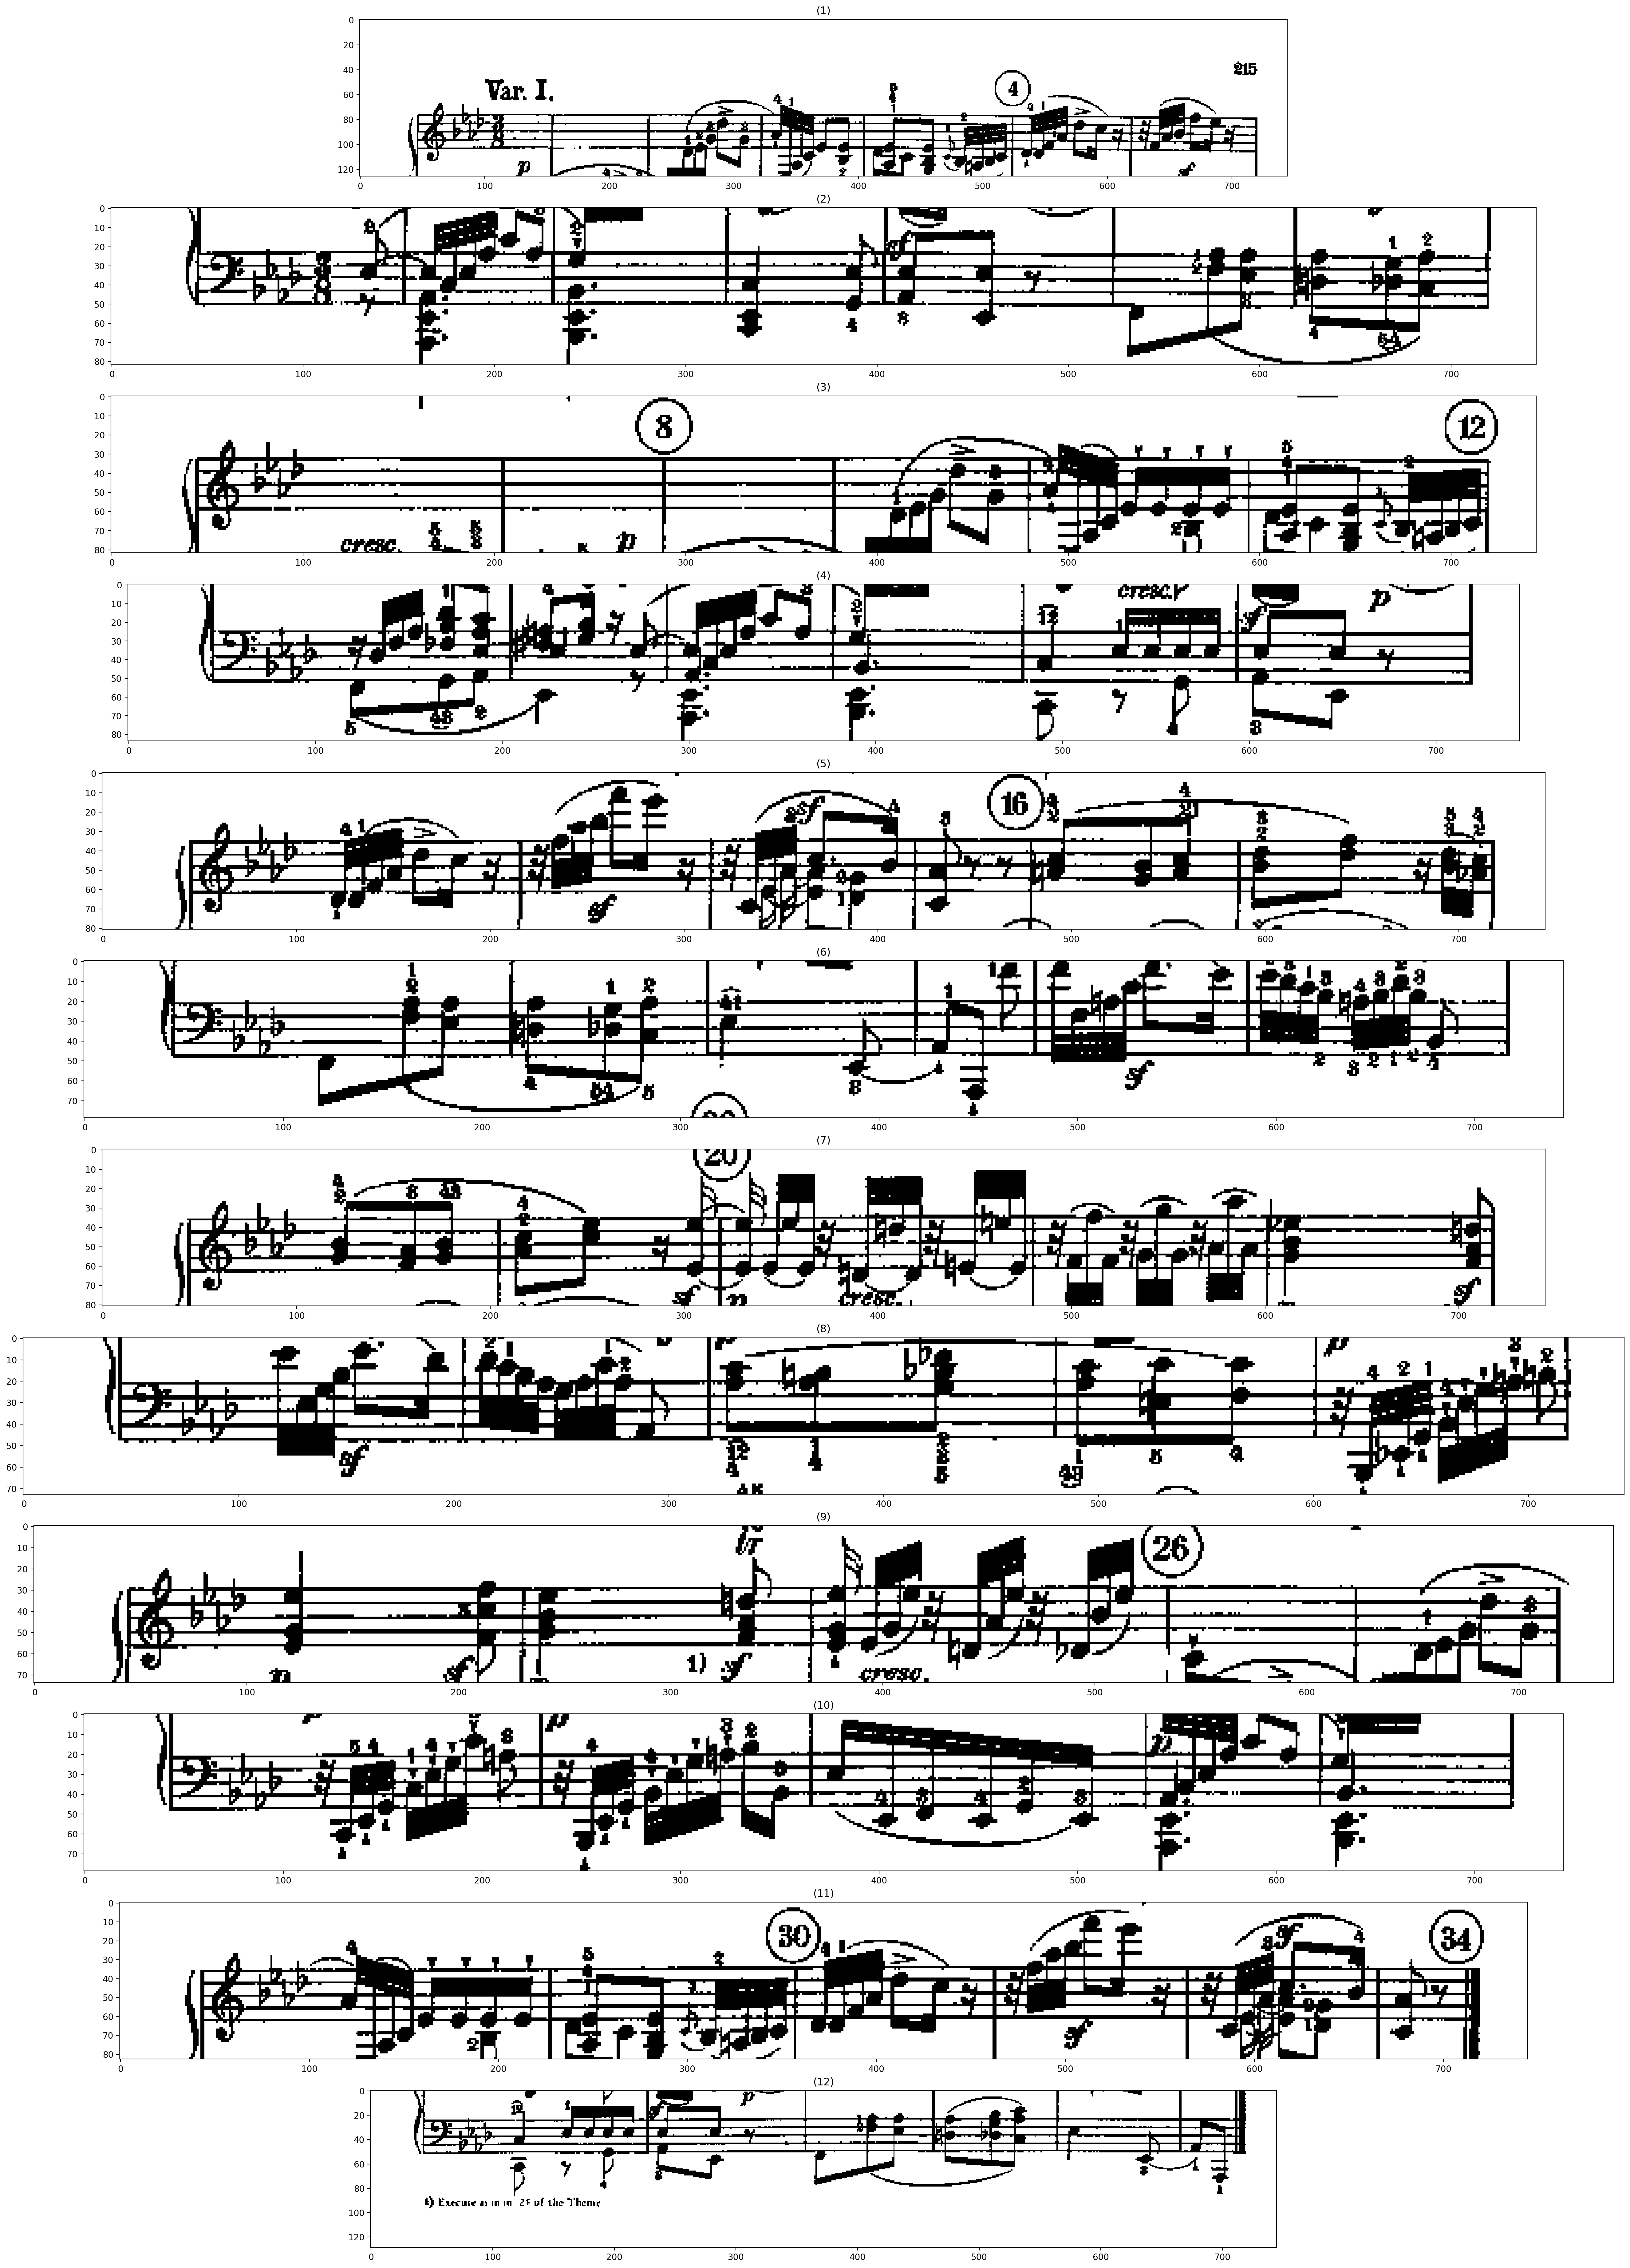

In [9]:
my_show_images(lines, row_max=1)

In [10]:
get_distance_between_staves(Beethoven_bin_bg_white)

4

In [11]:
get_distance_between_staves(test3_bin_bg_white)

4

In [12]:
get_distance_between_staves(test3_w1500_bin_bg_white)

15

In [13]:
get_distance_between_staves(test5_bin_bg_white)

19